# ANÁLISIS DE REDES SOCIALES CON PYTHON
## Diego Polo Benito
### 3 octubre 2021

In [1]:
from secretos import twitter_keys as tk
import tweepy
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nxcom
import operator
import matplotlib.pyplot as plt

In [2]:
def extract_connections_from_status(status, mentions, replies, retweets):
    for mention in status.entities['user_mentions']:
        mentions.append((status.user.screen_name, mention['screen_name']))
        if 'retweeted_status' in status._json:
            retweets.append((status.user.screen_name, status.retweeted_status.user.id))
        elif status.in_reply_to_screen_name:
            replies.append((status.user.screen_name, status.in_reply_to_screen_name))

## Captura de datos

In [3]:
# tk es dict. Ejemplo en secretos_fake.py

auth = tweepy.OAuthHandler(tk['APIKey'], tk['APIKeySecret'])
auth.set_access_token(tk['AccessToken'], tk['AccessTokenSecret'])

api = tweepy.API(auth)

# MODIFICAR EL VALOR DE items() PARA MAS TWEETS.------------------------|
#                                                                       |
#                                                                      \/
statuses = tweepy.Cursor(api.search_tweets, "Trump", count=500).items(1000)

mentions = []
replies = []
retweets = []
for status in statuses:
    extract_connections_from_status(status, mentions, replies, retweets)

df = pd.DataFrame(mentions+replies+retweets, columns =['from', 'to'])
df.to_csv('trump_graph.csv', sep=',', header=False, index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407 entries, 0 to 2406
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   from    2407 non-null   object
 1   to      2407 non-null   object
dtypes: object(2)
memory usage: 37.7+ KB


In [4]:
df.head()

,from,to
0,gehenna4Life,AaronParnas
1,deadbloke,Secret_Junkyard
2,deadbloke,MrPaulRobinson
3,JoanneCangal,AaronParnas
4,FlagKnitter,glennkirschner2


## Grafo

In [6]:
G = nx.read_edgelist('trump_graph.csv', delimiter=',')
nodes = [k[0] for k in G.degree if k[1]>=15]
G_simple = G.subgraph(nodes)

In [7]:
print("Info")
print(f"G: {nx.info(G)} G_simple: {nx.info(G_simple)}")
print("Density")
print(f"G: {nx.density(G)} G_simple: {nx.density(G_simple)}")

Info
G: Graph with 1596 nodes and 1781 edges G_simple: Graph with 14 nodes and 4 edges
Density
G: 0.0013992661905547568 G_simple: 0.04395604395604396


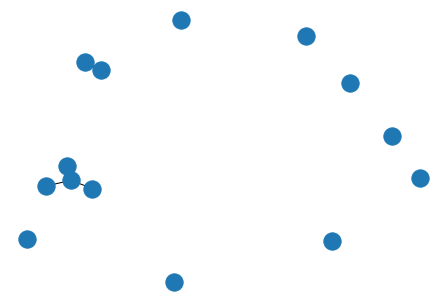

In [8]:
nx.draw(G_simple)

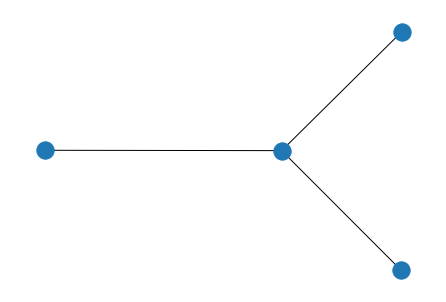

In [9]:
largest_cc = max(nx.connected_components(G_simple), key=len)
G_simple_conn = G_simple.subgraph(largest_cc)
nx.draw(G_simple_conn)

In [10]:
btw_cen = [(node, nx.betweenness_centrality(G)[node]) for node in G_simple_conn.nodes()]
print(f"Nodo con maxima centralidad de intermediacion: {sorted(btw_cen, key = lambda x: x[1])[0][0]}",
      f" con {sorted(btw_cen, key = lambda x: x[1])[0][1]}")

Nodo con maxima centralidad de intermediacion: ClaraGu05568105  con 0.004633075644024582


In [11]:
katz_cen = nx.katz_centrality(G_simple_conn)
print(f"Nodo con maxima centralidad de katz: {sorted(katz_cen.items(), key = operator.itemgetter(1))[0][0]}",
      f" con {sorted(katz_cen.items(), key = operator.itemgetter(1))[0][1]}")

Nodo con maxima centralidad de katz: stuartpstevens  con 0.47691049988629


In [12]:
coms = nxcom.greedy_modularity_communities(G_simple_conn)
com_colors = []
for id_c, c in enumerate(coms):
    for node in c:
        G.nodes[node]['community'] = id_c + 1
        G.nodes[node]['comm_color'] = id_c + 1

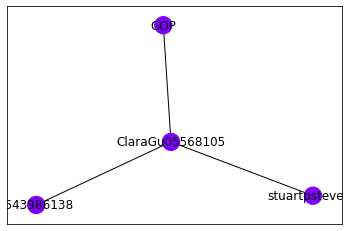

In [13]:
pos = nx.spring_layout(G_simple_conn)
nx.draw_networkx(G_simple_conn, cmap=plt.get_cmap("rainbow"), 
                 pos = pos, node_color=[G_simple_conn.nodes[_]['comm_color'] for _ in G_simple_conn.nodes], label=False)